# Train a `biolord` model with `sci-Plex 3` 

This notebook relies on pre-processed data obtained in [`1_perturbations_sciplex3_preprocessing.ipynb`](https://github.com/nitzanlab/biolord_reproducibility/blob/main/notebooks/perturbations/sciplex3/1_perturbations_sciplex3_preprocessing.ipynb).<br>
Alternatively the processed adata can be downloaded from figshare, [`sciplex3_biolord.h5ad`](https://figshare.com/ndownloader/files/39324305).

Here we train a `biolord` model on the `sci-Plex 3`[[1]](https://www.science.org/doi/10.1126/science.aax6234) dataset and compare the performance to `chemCPA`[[2]](https://openreview.net/forum?id=vRrFVHxFiXJ)

** hyperparameters were chosen using a paramater optimization scheme provided in `scriprts/biolord/sciplex3`

[[1] Srivatsan, S. R., McFaline-Figueroa, J. L., Ramani, V., Saunders, L., Cao, J., Packer, J., ... & Trapnell, C. (2020). Massively multiplex chemical transcriptomics at single-cell resolution. Science, 367(6473), 45-51.](https://www.science.org/doi/10.1126/science.aax6234)

[[2] Hetzel, Leon, Simon Böhm, Niki Kilbertus, Stephan Günnemann, Mohammad Lotfollahi, and Fabian Theis. "Predicting Cellular Responses to Novel Drug Perturbations at a Single-Cell Resolution" Advances in Neural Information Processing Systems (2022).](https://openreview.net/forum?id=vRrFVHxFiXJ)


## load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import torch
import anndata as ad
from sklearn import metrics, cluster

import biolord

import umap.plot

import seaborn as sns
import matplotlib.pyplot as plt

[rank: 0] Global seed set to 0


In [3]:
sys.path.append("../../../")
sys.path.append("../../../utils/")

from paths import DATA_DIR, FIG_DIR

In [4]:
from utils.utils_perturbations_sciplex3 import compute_prediction, compute_baseline, create_df
from utils.parameters_sciplex3 import (
    groups,
    groups_colors,
    module_params,
    trainer_params,
    ood_drugs,
)

## set parameters

In [5]:
import mplscience

mplscience.set_style()

plt.rcParams["legend.scatterpoints"] = 1

In [6]:
DATA_DIR_LCL = str(DATA_DIR) + "/perturbation/"
FIG_DIR_LCL = str(FIG_DIR) + "/perturbation/"

## Setup anndata

In [7]:
adata = sc.read(
    DATA_DIR_LCL + "sciplex3_biolord.h5ad",
    backup_url="https://figshare.com/ndownloader/files/39324305",
)

In [8]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=["rdkit2d_dose"],
    categorical_attributes_keys=["cell_type"],
    retrieval_attribute_key=None,
)

INFO     Generating sequential column names                                                                        


## Train a model

In [9]:
model = biolord.Biolord(
    adata=adata,
    n_latent=256,
    model_name="sciplex3",
    module_params=module_params,
    train_classifiers=False,
    split_key="split_ood",
)

[rank: 0] Global seed set to 42


In [11]:
model.train(
    max_epochs=200,
    batch_size=512,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory biolord_log/sciplex3_Biolord/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 132/200:  66%|██████▌   | 132/200 [58:46<30:16, 26.71s/it, v_num=1, val_generative_mean_accuracy=0.987, val_generative_var_accuracy=0.921, val_biolord_metric=0.954, val_reconstruction_loss=328, val_unknown_attribute_penalty_loss=0, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=329, unknown_attribute_penalty_loss=1.02e+5]      
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.954. Signaling Trainer to stop.


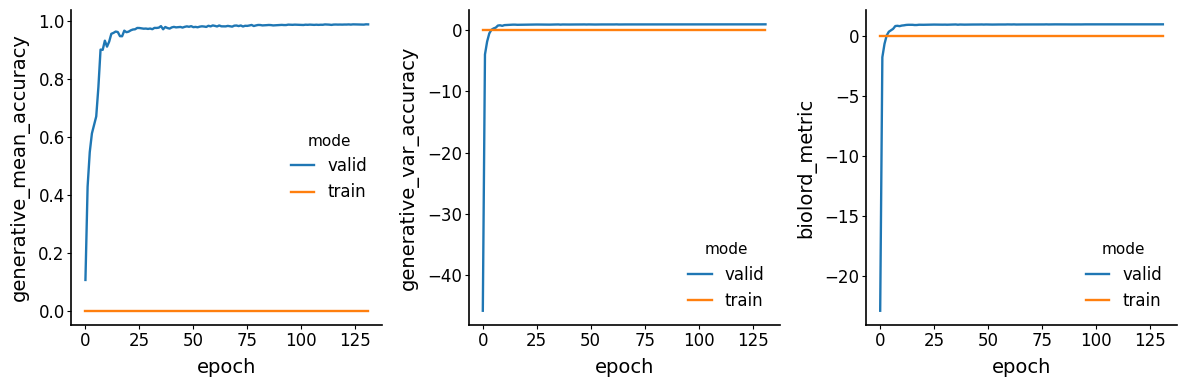

In [20]:
vals = ["generative_mean_accuracy", "generative_var_accuracy", "biolord_metric"]
fig, axs = plt.subplots(nrows=1, ncols=len(vals), figsize=(4 * len(vals), 4))

model.epoch_history = pd.DataFrame().from_dict(model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history,
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

## Evaluate performance

In [13]:
idx_test_control = np.where(
    (adata.obs["split_ood"] == "test") & (adata.obs["control"] == 1)
)[0]

adata_test_control = adata[idx_test_control].copy()

idx_ood = np.where((adata.obs["split_ood"] == "ood"))[0]

adata_ood = adata[idx_ood].copy()
dataset_control = model.get_dataset(adata_test_control)
dataset_ood = model.get_dataset(adata_ood)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [14]:
res_all = {}

res_all["baseline"], _ = compute_baseline(
    model=model,
    adata=adata_ood,
    dataset=dataset_ood,
    dataset_control=dataset_control,
    use_DEGs=False,
    verbose=False,
)

res_all["biolord"], _ = compute_prediction(
    model=model,
    adata=adata_ood,
    dataset=dataset_ood,
    dataset_control=dataset_control,
    use_DEGs=False,
    verbose=False,
)

['A549', 'K562', 'MCF7']


108it [00:00, 427.53it/s]


['A549', 'K562', 'MCF7']


108it [00:00, 131.84it/s]


In [15]:
df_all = create_df(res_all)
mean_all = df_all.groupby(by=["dose", "type"]).mean("r2_de").reset_index()
median_all = df_all.groupby(by=["dose", "type"]).median("r2_de").reset_index()

### Assess $r^{2}$ accuracy

Load `chemCPA` results.
To compute `chemCPA` results follow guidelines in `scripts/chemCPA`.

In [16]:
df_chem_pre = pd.read_csv(DATA_DIR_LCL + "chemCPA_pretrained_all.csv", index_col=0)
df_chem_pre["type"] = "chemCPA-pre"
df_chem = pd.read_csv(DATA_DIR_LCL + "chemCPA_nonpretrained_all.csv", index_col=0)
df_chem["type"] = "chemCPA"
df_full = pd.concat([df_all, df_chem, df_chem_pre])

In [17]:
df_full[df_full["dose"] == 1.0].groupby(by=["type"]).mean("r2_de")[
    "r2_de"
].sort_values()

type
baseline       0.380029
chemCPA        0.438451
chemCPA-pre    0.675838
biolord        0.762390
Name: r2_de, dtype: float64

In [18]:
df_full[df_full["dose"] == 1.0].groupby(by=["type"]).median("r2_de")[
    "r2_de"
].sort_values()

type
baseline       0.168575
chemCPA        0.353961
chemCPA-pre    0.766910
biolord        0.852794
Name: r2_de, dtype: float64

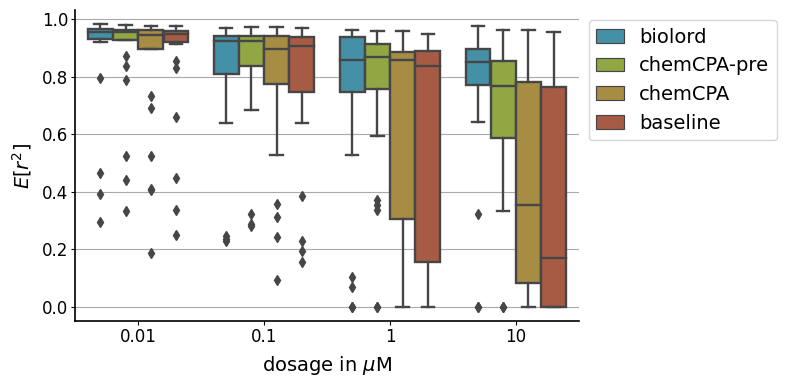

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

hue_order = ["biolord", "chemCPA-pre", "chemCPA", "baseline"]

sns.boxplot(
    data=df_full,
    x="dose",
    y="r2_de",
    hue="type",
    hue_order=hue_order,
    palette=["#339AB8", "#9AB833", "#b89433", "#b85133"],
    ax=axs,
)

x_labels = axs.get_xticklabels()
dose_labels = ["0.01", "0.1", "1", "10"]
[label.set_text(dose_labels[i]) for i, label in enumerate(x_labels)]
axs.set_xticklabels(x_labels)
axs.set_ylabel("$E[r^2]$", fontsize=14)
axs.set_xlabel("dosage in $\mu$M", fontsize=14)
axs.set_axisbelow(True)
axs.grid(".", color="darkgrey", axis="y")

axs.legend(
    title="",
    fontsize=14,
    title_fontsize=14,
    loc="upper left",
    frameon=True,
    bbox_to_anchor=(1, 1),
)

plt.tight_layout()
plt.savefig(FIG_DIR_LCL + "sciplex3_r2.png", format="png", dpi=300)
plt.show()

### Clustering drug embeddings

In [22]:
adata_high = adata[adata.obs["dose"].isin([10000])].copy()

In [23]:
rdkit2d_vals_high = []
pathways2 = []
pathways1 = []
drugs = []

for drug in adata_high.obs["drug_dose_name"].cat.categories:
    rdkit2d_vals_high.append(
        list(
            adata_high[adata_high.obs["drug_dose_name"].isin([drug])].obsm[
                "rdkit2d_dose"
            ][0, :]
        )
    )
    pathways2.append(
        adata_high[adata_high.obs["drug_dose_name"].isin([drug])]
        .obs["pathway_level_2"]
        .cat.categories[0]
    )
    pathways1.append(
        adata_high[adata_high.obs["drug_dose_name"].isin([drug])]
        .obs["pathway_level_1"]
        .cat.categories[0]
    )
    drugs.append(
        adata_high[adata_high.obs["drug_dose_name"].isin([drug])]
        .obs["product_name"]
        .cat.categories[0]
    )

rdkit2d_vals_high = np.asarray(rdkit2d_vals_high)
pathways1_groups = pd.Series(pathways1)
pathways1_groups[~pd.Series(pathways1).isin(groups)] = "NA"
pathways2_groups = pd.Series(pathways2)
pathways2_groups[~pd.Series(pathways2).isin(["Histone deacetylation"])] = "NA"
pathways1 = pd.Series(pathways1)
pathways1_groups[pathways1_groups == "Epigenetic regulation"] = pathways2_groups[
    pathways1_groups == "Epigenetic regulation"
]

drugs_ood = pd.Series(drugs)
drugs_ood[~pd.Series(drugs).isin(ood_drugs)] = "Observed"
drugs_ood[pd.Series(drugs).isin(ood_drugs)] = "Unseen"

In [24]:
# Get embedding
transf_embeddings_latent = model.get_ordered_attribute_embedding(
    attribute_key="rdkit2d_dose", vals=np.asarray(rdkit2d_vals_high)
)

# Get UMAPs
mapper_latent_rdkit = umap.UMAP().fit_transform(rdkit2d_vals_high[:, :-1])
mapper_latent_biolord = umap.UMAP().fit_transform(transf_embeddings_latent)

# Construct df
df = pd.DataFrame(mapper_latent_rdkit, columns=["umap1_rdkit", "umap2_rdkit"])
df[["umap1_biolord", "umap2_biolord"]] = mapper_latent_biolord  # mapper_latent_biolord

df["Pathways"] = pathways1_groups.values
df["Drugs"] = drugs_ood.values

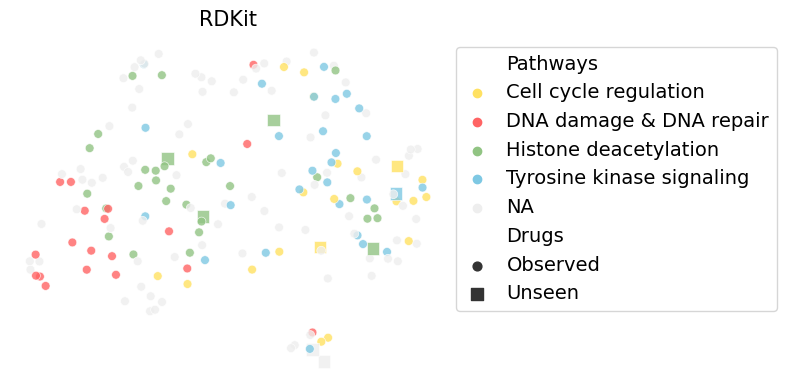

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

sns.scatterplot(
    data=df,
    x="umap1_rdkit",
    y="umap2_rdkit",
    hue="Pathways",
    hue_order=[
        "Cell cycle regulation",
        "DNA damage & DNA repair",
        "Histone deacetylation",
        "Tyrosine kinase signaling",
        "NA",
    ],
    style="Drugs",
    size="Drugs",
    sizes=(80, 40),
    markers=["o", "s"],
    ax=axs,
    alpha=0.8,
    palette=[
        "#FFE162",
        "#FF6464",
        "#91C483",
        "#7EC8E3",
        "#EEEEEE",
    ],
)

axs.set(xticklabels=[], yticklabels=[])
axs.set_xlabel("umap1")
axs.set_ylabel("umap2")

axs.grid(False)
axs.axis("Off")
axs.legend(
    title="",
    fontsize=14,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    ncols=1,
    frameon=True,
)
plt.title("RDKit")
plt.tight_layout()


plt.savefig(FIG_DIR_LCL + "umap_drug_embedding_rdkit.png", format="png", dpi=300)
plt.show()

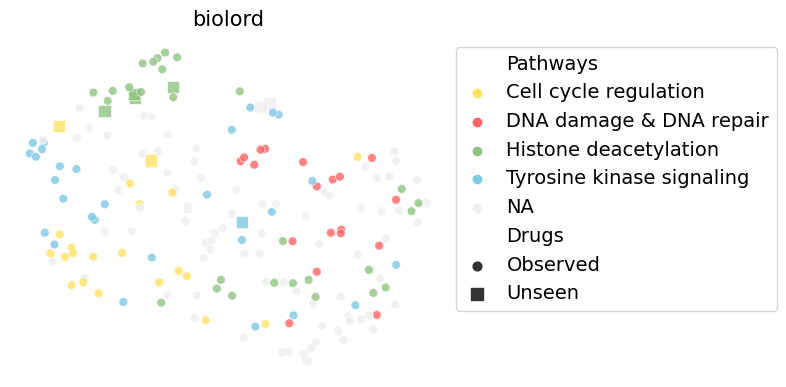

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

sns.scatterplot(
    data=df,
    x="umap1_biolord",
    y="umap2_biolord",
    hue="Pathways",
    hue_order=[
        "Cell cycle regulation",
        "DNA damage & DNA repair",
        "Histone deacetylation",
        "Tyrosine kinase signaling",
        "NA",
    ],
    style="Drugs",
    size="Drugs",
    sizes=(80, 40),
    markers=["o", "s"],
    ax=axs,
    alpha=0.8,
    palette=[
        "#FFE162",
        "#FF6464",
        "#91C483",
        "#7EC8E3",
        "#EEEEEE",
    ],
)

axs.set(xticklabels=[], yticklabels=[])
axs.set_xlabel("umap1")
axs.set_ylabel("umap2")

axs.grid(False)
axs.axis("Off")
axs.legend(
    title="",
    fontsize=14,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    ncols=1,
    frameon=True,
)
plt.title("biolord")
plt.tight_layout()


plt.savefig(FIG_DIR_LCL + "umap_drug_embedding_biolord.png", format="png", dpi=300)
plt.show()

### Score embedding

In [27]:
labels_methods = {}
labels_true = df["Pathways"].values
X_methods = {"biolord": transf_embeddings_latent, "rdkit": rdkit2d_vals_high[:, :-1]}

In [28]:
for key, X in X_methods.items():
    _, labels_methods[key], _ = cluster.k_means(
        X, n_clusters=df["Pathways"].unique().shape[0], n_init="auto", random_state=4
    )

In [29]:
for key, labels in labels_methods.items():
    print(key)
    print(
        f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}"
    )
    print("\n")

biolord
Adjusted Rand Index: 0.159


rdkit
Adjusted Rand Index: 0.028


